# Second approach

In [257]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [258]:
plt.style.use(plt.style.available[9])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Transfer Function

In [259]:
numerator = [-1, 1.9, 0.95]
denominator = [1, -0.18, 0.08, -0.08]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([-1.  ,  1.9 ,  0.95]), array([ 1.  , -0.18,  0.08, -0.08]))

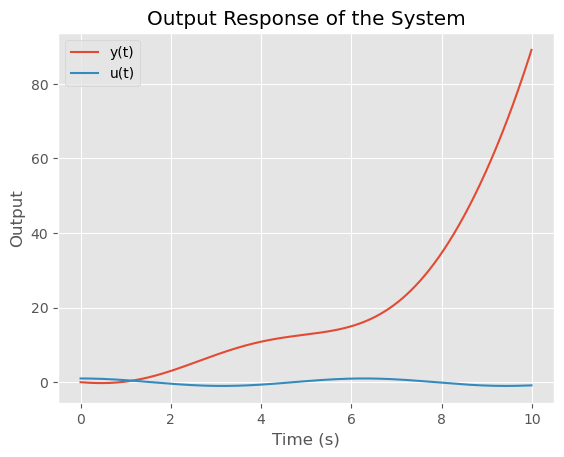

In [260]:
dt =0.01
time = np.arange(0, 10, dt)
f = 1
u_data = np.cos(f*time)#+np.cos(2*time)+np.cos(3*time)

# Step 3: Simulate the output using forced_response
results = ctrl.forced_response(H_s, T=time, U=u_data)

# Plotting the results
plt.figure()
plt.plot(results.time, results.outputs,label='y(t)')
plt.plot(time,u_data,label='u(t)')
plt.title('Output Response of the System')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()

plt.show()

## Neural Network

In [261]:
class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.ReLU())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Generating White Noise Data

In [262]:
def generate_delayed_data(data, delays):
    delayed_data = []
    for delay in delays:
        padded_data = torch.cat([torch.zeros(delay), data[:-delay]])
        delayed_data.append(padded_data)
    return torch.stack(delayed_data, dim=1)

In [263]:
# Example white noise input signal
torch.manual_seed(42)
input_signal = torch.randn(50)
time = np.arange(0, 10, 0.2)
input_delays = [1, 2]
output_delays = [1, 2]

# Generate delayed input data
input_data_d = generate_delayed_data(input_signal, input_delays)
input_data = torch.cat([input_signal.reshape(-1, 1), input_data_d], dim=1).to(device)

# Generate system response using control library
T, y_ = ctrl.forced_response(H_s, T=time, U=input_signal.numpy())

# Convert output response to PyTorch tensor and generate delayed outputs
output_signal = torch.from_numpy(y_)  # Convert to PyTorch tensor
output_data = generate_delayed_data(output_signal, output_delays).to(device)

In [264]:
model = DeepNetwork(input_dim=input_data.shape[1] + output_data.shape[1], hidden_dims=[64], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the data
X = torch.cat([input_data, output_data], dim=1).to(device).float()
y = torch.from_numpy(y_).to(device).float().reshape(-1,1)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch %5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 62.48456573486328
Epoch 5000, Loss: 0.00017226494674105197


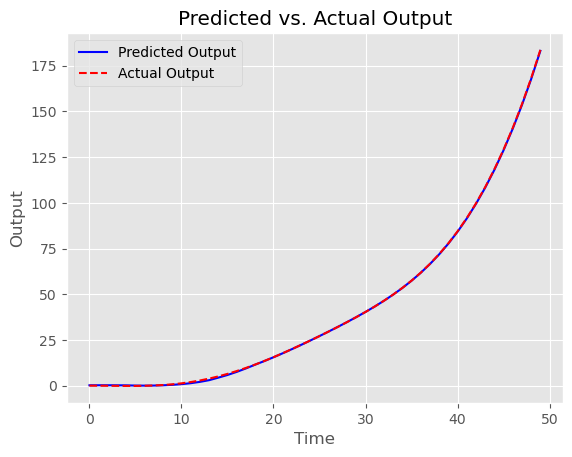

In [265]:
# Test the model with a new input signal (e.g., a sine wave)
test_input = torch.sin(torch.linspace(0, 10, 50))
test_input_data = generate_delayed_data(test_input, input_delays)
test_input_data = torch.cat([test_input.reshape(-1, 1), test_input_data], dim=1).to(device)

T, y_ = ctrl.forced_response(H_s, T=time, U=test_input.numpy())
test_output_data = generate_delayed_data(torch.from_numpy(y_), output_delays).to(device)
X_test = torch.cat([test_input_data, test_output_data], dim=1).to(device).float()

# Combine delayed test input and output for prediction
X_test = torch.cat([test_input_data, test_output_data], dim=1).to(device).float()
predicted_output = model(X_test)

# Plot predicted output and actual output
plt.plot(predicted_output.detach().cpu().numpy(), label="Predicted Output", color="blue")
T, y_ = ctrl.forced_response(H_s, T=time, U=test_input.numpy())
plt.plot(y_, label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()